In [36]:
import datetime as dt
import pandas as pd
import numpy as np
import pandas_datareader as dr
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf

yf.pdr_override()  ## for fixing pandas data reader error

In [130]:
stock_name =["TCS","SBIN"]
stock_name =[ x+".NS" for x in stock_name]

start =dt.date.today()-dt.timedelta(days=2000)

df= dr.data.get_data_yahoo(stock_name[0],start,end =dt.date.today())

[*********************100%***********************]  1 of 1 downloaded


In [131]:
df1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-15,1144.43,1145.85,1127.50,1130.55,1012.47,3269408
2016-01-18,1131.00,1145.95,1130.00,1138.82,1019.88,2213922
2016-01-19,1138.50,1150.00,1134.15,1139.65,1020.62,967910
2016-01-20,1136.90,1142.50,1121.50,1140.05,1020.98,1615954
2016-01-21,1142.50,1144.95,1122.88,1127.25,1011.96,2675536


In [132]:
df.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1348 entries, 2016-01-15 to 2021-07-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1348 non-null   float64
 1   High       1348 non-null   float64
 2   Low        1348 non-null   float64
 3   Close      1348 non-null   float64
 4   Adj Close  1348 non-null   float64
 5   Volume     1348 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 73.7 KB


In [136]:
df1=df.reset_index()["Close"]

0       1130.55
1       1138.82
2       1139.65
3       1140.05
4       1127.25
         ...   
1343    3345.75
1344    3341.50
1345    3325.45
1346    3321.00
1347    3262.30
Name: Close, Length: 1348, dtype: float64

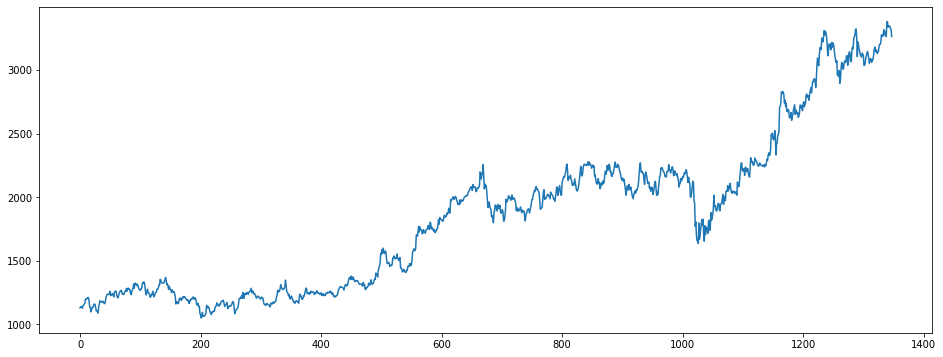

In [137]:
df1.plot(figsize=(16,6))

In [138]:
df1.shape

(1348,)

In [139]:
from sklearn.preprocessing import MinMaxScaler
scaler =MinMaxScaler(feature_range=(0,1))
df1= scaler.fit_transform(np.array(df1).reshape(-1,1))

In [140]:
df1

array([[0.03432279],
       [0.0378718 ],
       [0.03822799],
       ...,
       [0.97624698],
       [0.9743373 ],
       [0.94914665]])

In [142]:
## spliting the data in train test

size = int(len(df1)*.75)
train_data= df1[0:size,:]
test_data=df1[size:,:]

In [143]:
def create_dataset(data,time_step=3):
    x_data,y_data=[],[]
    
    for i in range(len(data)-time_step-1):
        a=data[i:i+time_step,0]
        x_data.append(a)
        y_data.append(data[i+time_step,0])
        
    return np.array(x_data),np.array(y_data)

In [144]:
time_step=100

x_train,y_train = create_dataset(train_data,time_step)
x_test,y_test =create_dataset(test_data,time_step)

In [145]:
print(x_train.shape)
print(y_train.shape)

(910, 100)
(910,)


In [146]:
# reshaping input for LSTM input type [samples,time_steps,fetures]
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test =x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [147]:
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam

In [148]:
## stacked Lstm model

model =Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mse",optimizer='adam')

In [149]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [150]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
15/15 [==============================] - 3s 189ms/step - loss: 0.0195 - val_loss: 0.0871
Epoch 2/10
15/15 [==============================] - 1s 85ms/step - loss: 0.0035 - val_loss: 0.0232
Epoch 3/10
15/15 [==============================] - 1s 86ms/step - loss: 0.0013 - val_loss: 0.0084
Epoch 4/10
15/15 [==============================] - 1s 88ms/step - loss: 0.0011 - val_loss: 0.0088
Epoch 5/10
15/15 [==============================] - 1s 87ms/step - loss: 8.8495e-04 - val_loss: 0.0080
Epoch 6/10
15/15 [==============================] - 1s 90ms/step - loss: 8.6214e-04 - val_loss: 0.0075
Epoch 7/10
15/15 [==============================] - 1s 91ms/step - loss: 8.5128e-04 - val_loss: 0.0102
Epoch 8/10
15/15 [==============================] - 1s 86ms/step - loss: 8.5532e-04 - val_loss: 0.0089
Epoch 9/10
15/15 [==============================] - 1s 95ms/step - loss: 8.3163e-04 - val_loss: 0.0071
Epoch 10/10
15/15 [==============================] - 1s 91ms/step - loss: 8.9417e-04 - v

In [151]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [152]:
train_predict[0]

array([0.10762651], dtype=float32)

In [153]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [155]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1697.3244909027399

In [157]:
math.sqrt(mean_squared_error(y_test,test_predict))

2691.7496496466624

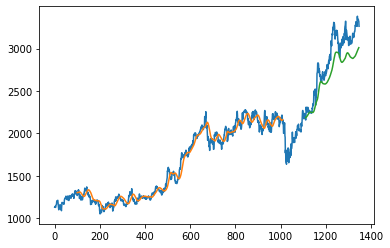

In [159]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()